<a href="https://colab.research.google.com/github/shankartmv/Deep-Learning-Work/blob/main/IMDB_Sentiment_reviews_using_tensorflow_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Idea inspired from / reference 

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

https://cloudxlab.com/assessment 

Goal : Build a model that would predict the sentiment/label (Good or Bad - 2 classes) based on the reviews provided Note : We are going to use the Glove embedding vector from the open dataset and we are not going to learn the embedding initially. If required , based on the accuracy we will fine tune the model further.

In [ ]:
!lshw -numeric -C display

/bin/bash: lshw: command not found


In [ ]:
import numpy as np
from keras.callbacks import ModelCheckpoint
import re
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns
import chardet
import keras.utils.vis_utils as kutils
from operator import itemgetter
from keras.initializers import Constant
import pandas as pd

%matplotlib inline

In [ ]:
print(tf.__version__)
print(tf.executing_eagerly())
print(keras.__version__)

2.4.0
True
2.4.3


In [ ]:
train_dataset,train_info=tfds.load('imdb_reviews',with_info=True,split='train+test[:80%]')
test_dataset,test_info=tfds.load('imdb_reviews',with_info=True,split='test[80%:100%]')

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC7PEUI/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC7PEUI/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC7PEUI/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print('Size of training dataset = ',train_dataset.cardinality(),'\nSize of test dataset = ',test_dataset.cardinality())
print('Train dataset type = ',type(train_dataset),'\nTest dataset type = ',type(test_dataset))
# Elements under the dataset is again a dictionary of tensor objects(values)
print('Train dataset contents = ',train_dataset.element_spec,'\nTrain dataset contents = ',test_dataset.element_spec)

Size of training dataset =  tf.Tensor(45000, shape=(), dtype=int64) 
Size of test dataset =  tf.Tensor(5000, shape=(), dtype=int64)
Train dataset type =  <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 
Test dataset type =  <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Train dataset contents =  {'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)} 
Train dataset contents =  {'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}


In [ ]:
def process_dataset(ip_dataset,name):
# There were few problems using a map function , bug in fact . Hence I didn't want to complicate further and the following loop
# took only few seconds to complete. This is the issue I was referring - https://github.com/tensorflow/tensorflow/issues/32842
    
# A word about num_words parameter in tokenizer. 
# https://stackoverflow.com/questions/63658449/use-of-num-words-in-the-tokenizer-class-in-keras/63658573#63658573

    tokn=Tokenizer(num_words=20000,oov_token='UNK')
    word_list=[]
    label_list=[]
    for reviews in ip_dataset.as_numpy_iterator():
        review_comments=str(reviews['text'],encoding='utf8')
        review_comments=re.sub("<br\s*/?>"," ",review_comments)
        #review_comments=re.sub("[^a-zA-Z']"," ",review_comments)
        word_list.append(review_comments)
        label_list.append(reviews['label'])
    
    # Check if we have all the reviews covered in the training set    
    
    print(name.upper()+' STATS ',end='\n~~~~~~~~~~~~\n')
    print(name,' dataset length (total reviews in word_list) = ',len(word_list))
    print('Max & Min length of the reviews = ',max(list(map(len,word_list))),' & ',min(list(map(len,word_list))))
    
    #print(*word_list[0:10],sep="\n-------------------------------------\n")
    
    tokn.fit_on_texts(word_list)
    
    # The reason behind adding 1 is that in the embedding matrix where the feature vectors is as follows
    
    vocab_size=len(tokn.word_index)+1
    print('Vocabulary size = ',vocab_size)
    print('Number of reviews post word to index mappings for the sake of verification. This should be equal to dataset size : ',tokn.document_count)
    print("number of unique words in our entire list of reviews = ",len(tokn.word_index))
    encoded_reviews=tokn.texts_to_sequences(word_list)
    
    #print(tokn.word_counts) # this returns an ordered dictionary. the key,value insertion order is preserved as compared to normal dictionary
    # Note : trying to run tokn.get_config() resulted in a warning message from jupyter notebooks and subsequently the kernel had to be restarted
    # Now that each word in our review has been assigned a index (integer) & their counts are also available, let's encode each review
    # (entire review) to indexes . for ex:- "that was a hilarious movie" would be encoded to  11,45,2,28,12
    max_length=max(list(map(len,encoded_reviews)))
    print('Length of the longest review after encoding each of the word in the review to integers = ',max_length,'\nNote that the length would be different for reviews with wordings and integer mappings')
    print('Type of encoded reviews = ',type(encoded_reviews),'\nType of label_list = ',type(label_list),'\n------------------------------------------------------------------------------------')
    return encoded_reviews,label_list,max_length,vocab_size,tokn

In [ ]:
train_encoded_reviews,train_labels,train_max_length,train_vocab_size,train_tokn=process_dataset(train_dataset,'train')
test_encoded_reviews,test_labels,test_max_length,test_vocab_size,test_tokn=process_dataset(test_dataset,'test')
max_length=max(train_max_length,test_max_length)
print('Longest encoded review length (train+test) = ',max_length)

TRAIN STATS 
~~~~~~~~~~~~
train  dataset length (total reviews in word_list) =  45000
Max & Min length of the reviews =  13604  &  32
Vocabulary size =  118431
Number of reviews post word to index mappings for the sake of verification. This should be equal to dataset size :  45000
number of unique words in our entire list of reviews =  118430
Length of the longest review after encoding each of the word in the review to integers =  2473 
Note that the length would be different for reviews with wordings and integer mappings
Type of encoded reviews =  <class 'list'> 
Type of label_list =  <class 'list'> 
------------------------------------------------------------------------------------
TEST STATS 
~~~~~~~~~~~~
test  dataset length (total reviews in word_list) =  5000
Max & Min length of the reviews =  6996  &  105
Vocabulary size =  42211
Number of reviews post word to index mappings for the sake of verification. This should be equal to dataset size :  5000
number of unique words in our

In [ ]:
from google.colab import drive

In [ ]:
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
print(train_tokn.index_word)
# This number proves if the max number of words is equal to num_words parameter in tokenizer
# In a nut shell, this is the max number of words that we want to have in our vocabulary
print(list(map(min,train_encoded_reviews)))
print(type(train_labels),train_labels)

{1: 'UNK', 2: 'the', 3: 'and', 4: 'a', 5: 'of', 6: 'to', 7: 'is', 8: 'in', 9: 'it', 10: 'i', 11: 'this', 12: 'that', 13: 'was', 14: 'as', 15: 'for', 16: 'with', 17: 'movie', 18: 'but', 19: 'film', 20: 'on', 21: 'not', 22: 'you', 23: 'are', 24: 'his', 25: 'have', 26: 'be', 27: 'one', 28: 'he', 29: 'all', 30: 'at', 31: 'by', 32: 'an', 33: 'they', 34: 'so', 35: 'who', 36: 'from', 37: 'like', 38: 'or', 39: 'just', 40: 'her', 41: 'out', 42: 'about', 43: 'if', 44: "it's", 45: 'has', 46: 'there', 47: 'some', 48: 'what', 49: 'good', 50: 'more', 51: 'when', 52: 'very', 53: 'up', 54: 'no', 55: 'time', 56: 'my', 57: 'even', 58: 'she', 59: 'would', 60: 'which', 61: 'only', 62: 'really', 63: 'story', 64: 'see', 65: 'their', 66: 'had', 67: 'can', 68: 'me', 69: 'well', 70: 'were', 71: 'than', 72: 'much', 73: 'we', 74: 'been', 75: 'get', 76: 'bad', 77: 'do', 78: 'great', 79: 'other', 80: 'also', 81: 'will', 82: 'into', 83: 'people', 84: 'because', 85: 'first', 86: 'how', 87: 'him', 88: 'most', 89: "do

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lrt /content/drive/MyDrive/DeepLearning/Models

total 245018
-rw------- 1 root root 50179272 Jan  8 19:32 IMDB-weights-improvement-19-0.88.hdf5
-rw------- 1 root root 50179272 Jan  8 19:32 IMDB-weights-improvement-20-0.89.hdf5
-rw------- 1 root root 50179272 Jan  8 19:35 IMDB-weights-improvement-27-0.89.hdf5
-rw------- 1 root root 50179272 Jan  8 19:36 IMDB-weights-improvement-31-0.89.hdf5
-rw------- 1 root root 50179272 Jan  8 19:37 IMDB-weights-improvement-32-0.89.hdf5


In [ ]:
def min_max_histogram(ip_word_list):
    individual_reviews_length=list(map(len,ip_word_list))
    print(max(individual_reviews_length),min(individual_reviews_length))
    sns.histplot(individual_reviews_length,binrange=(0,1000),binwidth=100)
    return individual_reviews_length

2473 6


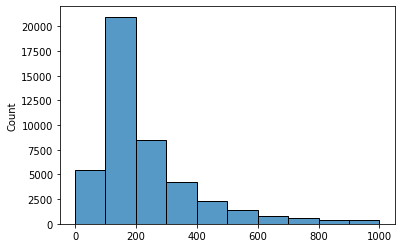

count    45000.000000
mean       231.278244
std        171.538027
min          6.000000
25%        127.000000
50%        173.000000
75%        281.000000
max       2473.000000
dtype: float64

In [ ]:
individual_reviews_length=min_max_histogram(train_encoded_reviews)
plt.show()
pd.Series(individual_reviews_length).describe()

1156 18


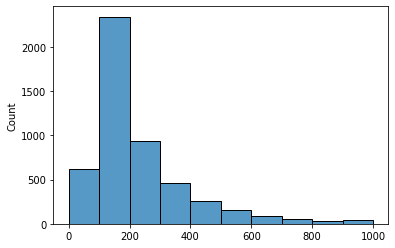

count    5000.000000
mean      228.437800
std       165.550807
min        18.000000
25%       126.000000
50%       171.000000
75%       276.000000
max      1156.000000
dtype: float64

In [ ]:
individual_reviews_length=min_max_histogram(test_encoded_reviews)
plt.show()
pd.Series(individual_reviews_length).describe()

In [ ]:
max_length=500
train_padded_reviews=pad_sequences(train_encoded_reviews,maxlen=max_length,padding='post')
test_padded_reviews=pad_sequences(test_encoded_reviews,maxlen=max_length,padding='post')

In [ ]:
vocab_size=20002
embedding_matrix=np.zeros((vocab_size,100))

In [ ]:
embedding_index=dict()

with open(r"/content/drive/.shortcut-targets-by-id/1zkSZEKfzV3RlDACueWwtVltLqrjyo31U/DeepLearning/Data/glove.6B.100d.txt") as dummy_file:
        result_encoding=chardet.detect(dummy_file.read(10000).encode())

print('File encoding as detected by chardet library : ',result_encoding)

# Even though chardet predicts the character encoding as ASCII, it resulted in errors while reading the file
# Hence after looking through the internet, utf-8 encoding didn't result in any errors

with open(r"/content/drive/.shortcut-targets-by-id/1zkSZEKfzV3RlDACueWwtVltLqrjyo31U/DeepLearning/Data/glove.6B.100d.txt",encoding='utf-8') as glove_file:
    for line in glove_file:
        values=line.split()
        word=values[0]
        weights=np.asarray(values[1:],dtype='float32')
        embedding_index[word]=weights
print('Loaded %s word vectors.' % (len(embedding_index)))

File encoding as detected by chardet library :  {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
Loaded 400001 word vectors.


In [ ]:
hits=0
misses=0
#Create a weight matrix for the words in embedding_reviews
for word,index in list(train_tokn.word_index.items())[:vocab_size-1]:
    #for word,index in train_tokn.word_index.items():
    embedding_features=embedding_index.get(word)
    if embedding_features is not None:
        embedding_matrix[index]=embedding_features
        hits+=1
    else:
        misses+=1
        
print("Converted %d words (%d misses)" % (hits, misses))

print(type(embedding_matrix),embedding_matrix)

model=keras.models.Sequential()
embedding=keras.layers.Embedding(vocab_size,100,input_length=max_length,name='EmbeddingLayer',embeddings_initializer=Constant(embedding_matrix),mask_zero=True,trainable=False)
lstm=keras.layers.LSTM(128,dropout=0.5,name='LSTM-1')
#model.add(keras.layers.Flatten())
dense=keras.layers.Dense(1, activation="sigmoid",name='Output')
model.add(embedding)
model.add(keras.layers.SpatialDropout1D(0.25))
model.add(lstm)
model.add(keras.layers.Dropout(0.2))
model.add(dense)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Converted 19246 words (755 misses)
<class 'numpy.ndarray'> [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.61576998 -0.29289001  0.057475   ... -0.35019001  0.91068
   0.22874001]
 [ 0.80063999 -0.060948   -0.35986999 ... -0.11248    -0.20765001
   0.15620001]]


In [ ]:
print(embedding.input_shape,embedding.output_shape)
print(lstm.input_shape,lstm.output_shape)
print(dense.input_shape,dense.output_shape)
print(model.summary())
print(type(train_labels),len(train_labels))
print(type(train_padded_reviews),type(np.array(train_labels)))
filepath="/content/drive/.shortcut-targets-by-id/1zkSZEKfzV3RlDACueWwtVltLqrjyo31U/DeepLearning/Models/IMDB-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

(None, 500) (None, 500, 100)
(None, 500, 100) (None, 128)
(None, 128) (None, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EmbeddingLayer (Embedding)   (None, 500, 100)          2000200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 500, 100)          0         
_________________________________________________________________
LSTM-1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 129       
Total params: 2,117,577
Trainable params: 117,377
Non-trainable params: 2,000,200
_________________________________________________________________
None
<class 'list'> 4500

In [ ]:
model.load_weights('/content/drive/.shortcut-targets-by-id/1zkSZEKfzV3RlDACueWwtVltLqrjyo31U/DeepLearning/Models/IMDB-weights-improvement-74-0.91.hdf5')

In [ ]:
print(type(train_padded_reviews),train_padded_reviews.shape)
print(type(np.array(train_labels)),np.array(train_labels).shape)
print(type(test_padded_reviews),test_padded_reviews.shape)
print(type(np.array(test_labels)),np.array(test_labels).shape)

<class 'numpy.ndarray'> (45000, 500)
<class 'numpy.ndarray'> (45000,)
<class 'numpy.ndarray'> (5000, 500)
<class 'numpy.ndarray'> (5000,)


In [ ]:
model.fit(train_padded_reviews,np.array(train_labels),epochs=90,verbose=2,validation_split=0.1,batch_size=1024,callbacks=callbacks_list)

Epoch 1/90


KeyboardInterrupt: ignored

In [ ]:
print(test_padded_reviews.shape,train_padded_reviews.shape)
print(np.array(test_labels).shape,np.array(train_labels).shape)

(5000, 500) (45000, 500)
(5000,) (45000,)


In [ ]:
model.evaluate(test_padded_reviews,np.array(test_labels),verbose=2)

157/157 - 2s - loss: 1.1110 - accuracy: 0.5464


[1.1110044717788696, 0.5464000105857849]

In [ ]:
print(test_dataset)

2487 2513 <class 'list'>
22513 2513 <class 'list'>
[   11    19     7    77    30     2  3326  4808 12475     4  2539     7
   309 12476     9     7  2490    17   212  1122     4    21     6   709
   421    22    75   188     6    61     9   171     4   171    51    51
   149    87     9    45     3    51   941   115    65     7  6142    22
   585   188     6   745    42    20     9     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0


In [ ]:
model.predict(np.atleast_2d(test_padded_reviews[1]))

array([[0.61087114]], dtype=float32)

In [ ]:
(model.predict(np.atleast_2d(test_padded_reviews[1])) > 0.5).astype('int32')

array([[1]], dtype=int32)